In [1]:
'''
   Scott Meyer
   
   Re-writing main process used in Nino Difference Index (NDI)
   box search process in Python (initally completed in MATLAB). 
   Initially done when I was a Research Assistant at Texas A&M 
   University working under Dr. John Nielsen-Gammon.
'''

#For plotting figures below cell
%matplotlib inline 
#import rest of packages
import datetime as dt
import numpy as np
import math
from netCDF4 import Dataset, num2date
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import csv as csv
import pandas as pd
import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry 
from matplotlib.patches import Rectangle

In [2]:
ENSOdir  = "C:\\Users\\Owner\\Documents\\python_dir\\ENSO\\"
ERSST    = ENSOdir + "ERSST\\sst.mnmean_updated.nc"
GPCP     = ENSOdir + "GPCP\\precip.mon.mean_updated.nc"

In [3]:
'''
"ncdump" function to make .nc data information more readable

Source: Chris Slocum
    http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html
'''

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.   
    
    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim)
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [4]:
''' 
    Recieved from Dr. John Nielsen-Gammon
    
    Define new class to extract gridded lon, lat data 
    using bounds of the desired region of data you want. 
    Input: Lat/Lon coordinates
'''

class LatLon:
    #This is why input of lon and lat info. can change the LatLon variable
    #to gather the correct and necessary information needed with the definitions below
    def __init__(self,lat0=-90,dlat=1,nlat=181,lon0=0,dlon=1,nlon=360):
        self.lat0 = lat0
        self.dlat = dlat
        self.nlat = nlat
        self.lon0 = lon0
        self.dlon = dlon
        self.nlon = nlon
        
    def il(self,i):
        lati = self.lat0 + self.dlat*i
        return lati
    
    def jl(self,j,w=True):
        loni = self.lon0 + self.dlon*j
        if w and loni > 180:
            loni = -(360 - loni)
        return loni
    
    def li(self,latval):
        i = int(round((latval-self.lat0)/self.dlat))
        if i < 0:
            i += self.nlat
        if i >= self.nlat:
            i += -self.nlat  
        return i

    def lj(self,lonval):
        j = int(round((lonval-self.lon0)/self.dlon))
        if j < 0:
            j += self.nlon
        if j >= self.nlon:
            j += -self.nlon
        return j
    
    def lltoij(self,latval,lonval):
        i = self.li(latval)
        j = self.lj(lonval)
        return i,j
    
    def latr(self,latval1,latval2):
        i1 = self.li(latval1)
        i2 = self.li(latval2)
        ist = min(i1,i2)
        ien = ist + abs(i2-i1) + 1
        return ist,ien
    
    def lonr(self,lonval1,lonval2):
        j1 = self.lj(lonval1)
        j2 = self.lj(lonval2)
        jst = min(j1,j2)
        jen = jst + abs(j2-j1) + 1
        return jst,jen

In [5]:
''' Load in SST data and retrieve information about ERSST dataset'''
SST_nc = Dataset(ERSST,'r')
nc_attrs,nc_dims,nc_vars = ncdump(SST_nc)

NetCDF Global Attributes:
	climatology: 'Climatology is based on 1971-2000 SST, Xue, Y., T. M. Smith, and R. W. Reynolds, 2003: Interdecadal changes of 30-yr SST normals during 1871.2000. Journal of Climate, 16, 1601-1612.'
	description: 'In situ data: ICOADS2.5 before 2007 and NCEP in situ data from 2008 to present. Ice data: HadISST ice before 2010 and NCEP ice after 2010.'
	keywords_vocabulary: 'NASA Global Change Master Directory (GCMD) Science Keywords'
	keywords: 'Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature >'
	instrument: 'Conventional thermometers'
	source_comment: 'SSTs were observed by conventional thermometers in Buckets (insulated or un-insulated canvas and wooded buckets) or Engine Room Intaker'
	geospatial_lon_min: -1.0
	geospatial_lon_max: 359.0
	geospatial_laty_max: 89.0
	geospatial_laty_min: -89.0
	geospatial_lat_max: 89.0
	geospatial_lat_min: -89.0
	geospatial_lat_units: 'degrees_north'
	geospatial_lon_units: 'degrees_east'
	cdm_data_type: 'Gr

In [6]:
'''Read in and view information for GPCP dataset'''
GPCP_nc = Dataset(GPCP,'r')
nc_attrs, nc_dims, nc_vars = ncdump(GPCP_nc)

NetCDF Global Attributes:
	Conventions: 'CF-1.0'
	curator: 'Dr. Jian-Jian Wang\nESSIC, University of Maryland College Park\nCollege Park, MD  20742  USA\nPhone: +1 301-405-4887'
	citation: 'Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P. Xie, J. Janowiak, B. \nRudolf, U. Schneider, S. Curtis, D. Bolvin, A. Gruber, J. Susskind, P. \nArkin, 2003: The Version 2 Global Precipitation Climatology Project \n(GPCP) Monthly Precipitation Analysis (1979 - Present). J. Hydrometeor., \n4(6), 1147-1167.'
	title: 'GPCP Version 2.3 Combined Precipitation Dataset (Final)'
	platform: 'NOAA POES (Polar Orbiting Environmental Satellites)'
	source_obs: 'CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS rainrates over land (Ferraro) \nGeo-IR (Xie) calibrated by SSMI/SSMIS rainrates for sampling \nTOVS/AIRS empirical precipitation estimates at higher latitudes \n(ocean and land) \nGPCC gauge analysis to bias correct satellite estimates over land and \nmerge with satellite based on sampling \nOLR Precip

In [7]:
''' Load in Sea Surface Temperature (SST) data variables '''
SSTlats = SST_nc.variables['lat'][:]  # extract/copy the data
SSTlons = SST_nc.variables['lon'][:] 
SSTtime = SST_nc.variables['time'][:]
SST = SST_nc.variables['sst'][:]  # shape is time (month), lat, lon as shown above
SSTdtime = num2date(SST_nc.variables['time'][:],SST_nc.variables['time'].units)
SSTnyears = SSTdtime[-1].year-SSTdtime[0].year 
#This uses the class LatLon where the input is starting lat, 
#lat_interval (dlat), and size to be used later for 
#definitions within class(e.g. for latr)
SSTll = LatLon(SSTlats[0],SSTlats[1]-SSTlats[0],
                 SST_nc.variables['lat'].size,
                 SSTlons[0],SSTlons[1]-SSTlons[0],
                 SST_nc.variables['lon'].size)

In [8]:
'''
   Range of months SST data spans and check
   to see if SST has any missing values.
   (-9.96e+36)
'''
print(SSTdtime[0],'to',SSTdtime[-1])
if np.min(SST) >= -1e+36:
    print('No missing values (',np.min(SST),'°C)')
else:
    print('Missing values')

1854-01-01 00:00:00 to 2021-10-01 00:00:00
No missing values ( -1.8 °C)


In [9]:
'''Load in GPCP data variables'''
GPCPlats = GPCP_nc.variables['lat'][:]
GPCPlons = GPCP_nc.variables['lon'][:]
GPCPtime = GPCP_nc.variables['time'][:]
precip = GPCP_nc.variables['precip'][:]  # shape is time, lat, lon as shown above
GPCPdtime = num2date(GPCP_nc.variables['time'][:],GPCP_nc.variables['time'].units)
GPCPll = LatLon(GPCPlats[0],GPCPlats[1]-GPCPlats[0],
                GPCP_nc.variables['lat'].size,
                GPCPlons[0],GPCPlons[1]-GPCPlons[0],
                GPCP_nc.variables['lon'].size)

In [10]:
'''Range of months GPCP data spans and
   check to see if GPCP has any missing 
   values (-9.96e+36)'''
print('GPCP:',GPCPdtime[0],'to',GPCPdtime[-1])
nyears_gpcp = GPCPdtime[-1].year-GPCPdtime[0].year

if np.min(precip) >= -1e+36:
    print('No missing values(',np.min(precip),'mm/day)')
else:
    print('Missing values')

GPCP: 1979-01-01 00:00:00 to 2021-10-01 00:00:00
No missing values( 0.0 mm/day)


In [11]:
'''
   Calculate seasonal gridpoint SST averages
   for full length of dataset.
'''


SST4 = np.zeros((4*SSTnyears,SSTlats.size,SSTlons.size))

for season in range(4):
    for year in range(SSTnyears):
        #indexes correct starting month for each season,
        #starting with March (MAM SST average is first 
        #index of new array)
        ym = year*12 + 2 + 3*season  
        SST4[season*SSTnyears+year,:,:] = np.mean(SST[ym:ym+3,:,:],axis=0)
        
SST4 = np.reshape(SST4,(4,SSTnyears,SSTll.nlat,SSTll.nlon))

#find first year of data to extract from SST4
#so it matches length of GPCP dataset
yr_extract_idx = SSTnyears-nyears_gpcp
SST4_gpcp_len = SST4[:,yr_extract_idx:,:,:]

In [12]:
'''
   Calculate seasonal gridpoint precipitation
   averages (units:mm) for full length of dataset.
'''
precipSeason = np.zeros((4,nyears_gpcp,
                         GPCP_nc.variables['lat'].size,                        
                         GPCP_nc.variables['lon'].size))

for season in range(4):
    for year in range(nyears_gpcp):
        ym = year*12 + 2 + 3*season
        #convert precip data from mm/day to mm
        p1 = precip[ym]*(GPCPdtime[ym+1]-GPCPdtime[ym]).days 
        p2 = precip[ym+1]*(GPCPdtime[ym+2]-GPCPdtime[ym+1]).days
        p3 = precip[ym+2]*(GPCPdtime[ym+3]-GPCPdtime[ym+2]).days
        precipSeason[season,year,:,:] = (p1 + p2 + p3)/3 #get average precip for Season

#area weighting function for PCA 
#(area of 1x1 degree of rainfall in tropics 
#much larger than in the poles)
precipArea = np.copy(precipSeason)
for ilat in range(GPCP_nc.variables['lat'].size):
    precipArea[:,:,ilat,:] = precipArea[:,:,ilat,:] * np.cos(np.deg2rad(GPCPlats[ilat]))

In [13]:
'''
   Principal component analysis function that finds the spatial variability map of 
   data for each mode and the corresponding principal component (PC) time series for 
   the leading modes of variability. Leading PC time series of precipitation data used 
   in box search process since ENSO is the leading mode of climate variability.
'''

def EOFanalysis(data,nyears):
    #creating arrays to store values
    pca = []
    pcaTS = []
    pca_expv = np.zeros((4,4)) #np array is (number of seasons) x (top 4 PC explained variance)
    pca_amp = np.zeros((4,4))
    pca_spat_var = []
    for season in range(4):
        if data.ndim == 4:
            X = np.reshape(data[season,:,:,:],
                           (nyears,-1)) #PCA only works on 2-d arrays. Throw lat/lon into 1-d
        else:
            X = np.reshape(data[season,:,:],
                          (nyears,-1))
            
        pca1 = PCA()
        pca.append(pca1)
        pca[season].fit(X[:nyears,:])
        pca_expv[season,:] = pca[season].explained_variance_ratio_[:4]
        pca_amp[season,:]  = pca[season].singular_values_[:4]
        pca_spat_var.append(pca[season].components_[:4])
        pcaTS.append(pca[season].fit_transform(X[:nyears,:]))
    
    #Spatial variability map for each principal component of data
    pca_spat_var_array = np.asarray(pca_spat_var) 
    pca_spat_var_array_float = np.array(pca_spat_var_array, dtype = 'float')
    
    #Time series for each leading principal component of data
    pcaTSarray = np.asarray(pcaTS) #change pcaTS from list to array    
    pcaTSarray_float = np.array(pcaTSarray, dtype = 'float') #change values to floats for later calculations

    return(pca_expv, pca_amp, pcaTSarray_float, pca_spat_var_array_float)

In [14]:
'''
   PCA calculations for global SST
'''
syear_idx = GPCPdtime[0].year - SSTdtime[0].year

sst_gpcp_len_global = SST4[:,syear_idx:,:,:]
sst_gpcp_len_global_pca = EOFanalysis(sst_gpcp_len_global,nyears_gpcp)
sst_gpcp_len_global_pc_expv = sst_gpcp_len_global_pca[0]
sst_gpcp_len_global_pcTS = sst_gpcp_len_global_pca[2]
sst_gpcp_len_global_pc_maps = sst_gpcp_len_global_pca[3]
sst_gpcp_len_global_pc_maps = sst_gpcp_len_global_pc_maps.reshape(4,4,SSTlats.size,
                                                                  SSTlons.size)

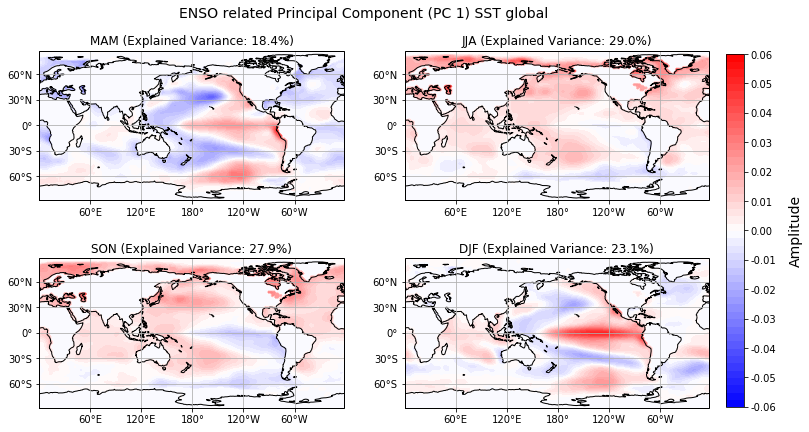

In [15]:
'''
   Plot figure for SST global PC 1 (Related to ENSO) spatial 
   variability map.
'''

#titles for subplots
season_name = ['MAM','JJA','SON','DJF']
#used to set cbarticks for contour plot
cbarticks = np.round(np.arange(-0.06,0.0625,0.0025),4)
lon2d, lat2d = np.meshgrid(SSTlons,SSTlats)
title_name = "ENSO related Principal Component (PC 1) SST global"

fig = plt.figure(figsize=(12,7))
for season in range(4):
    idx_subplot = season + 1
    #must use central_lon at equator to make map cross from MC to CP/EP region
    ax = fig.add_subplot(2,2,idx_subplot,
                         projection=ccrs.PlateCarree(central_longitude=180.0)) 
    
    plt.set_cmap('bwr')
    ax.coastlines(resolution='110m')
    ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                 ylocs = [-90,-60,-30,0,30,60,90], xlocs=[0,60,120,180,240,300,360])

    #remove gridline labels from top and right side of plots
    ax.xlabels_top = False
    ax.xlabels_bottom = True
    ax.ylabels_left = True
    ax.ylabels_right = False
    #Prints out latitude and longitude with proper coordinate system
    ax.set_xticks([60,120,180,-120,-60], crs = ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60], crs = ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    shading=ax.contourf(lon2d,lat2d,sst_gpcp_len_global_pc_maps[season,0,:,:],cbarticks,
                        transform=ccrs.PlateCarree())
    plt.title("%s %s %.1f%s" % (season_name[season],
                                "(Explained Variance:",100*sst_gpcp_len_global_pc_expv[season,0],"%)"))

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #input: left, bottom, width, height
cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8,format ='%.2f')
cbar.set_ticks(np.arange(-0.06,0.07,0.01))
cbarlabel = fig.text(1, 0.5, 'Amplitude', ha='center',
                     va='center',rotation='vertical', fontsize = 14)
header = fig.text(0.5,0.93,title_name, ha='center', va='center',fontsize = 14)

In [16]:
'''
   PCA for tropical, northern hemisphere, 
   and global precipitation.
'''
#GPCP tropical Region
latr = GPCPll.latr(-20,20)
lonr = GPCPll.lonr(90,-80)
GPCPtrop = precipArea[:,:,latr[0]:latr[1],lonr[0]:lonr[1]]
GPCPtrop_pca = EOFanalysis(GPCPtrop,nyears_gpcp)
GPCPtrop_pc_expv = GPCPtrop_pca[0]
GPCPtrop_pcTS = GPCPtrop_pca[2]
GPCPtrop_pc_maps = GPCPtrop_pca[3]
GPCPtrop_pc_maps = GPCPtrop_pc_maps.reshape(4,4,latr[1]-latr[0],
                                                lonr[1]-lonr[0])

#GPCP Northern Hemisphere Precipitation

#Set latitude for southern bound
#of nothern hemisphere precipitation
#to be northern indexed bound of GPCP
#tropical region.
lat_s_idx = latr[1]
GPCP_nhp = precipArea[:,:,lat_s_idx:,:]

GPCP_nhp = EOFanalysis(GPCP_nhp,nyears_gpcp)
GPCP_nhp_pc_expv = GPCP_nhp[0]
GPCP_nhp_pcTS = GPCP_nhp[2]
GPCP_nhp_pc_maps = GPCP_nhp[3]
GPCP_nhp_pc_maps = GPCP_nhp_pc_maps.reshape(4,4,GPCPlats.size-lat_s_idx,
                                                GPCPlons.size)

#GPCP global
GPCP_global = precipArea
GPCP_global_pca = EOFanalysis(GPCP_global,nyears_gpcp)
GPCP_global_pc_expv = GPCP_global_pca[0]
GPCP_global_pcTS = GPCP_global_pca[2]
GPCP_global_pc_maps = GPCP_global_pca[3]
GPCP_global_pc_maps = GPCP_global_pc_maps.reshape(4,4,GPCPlats.size,
                                                GPCPlons.size)

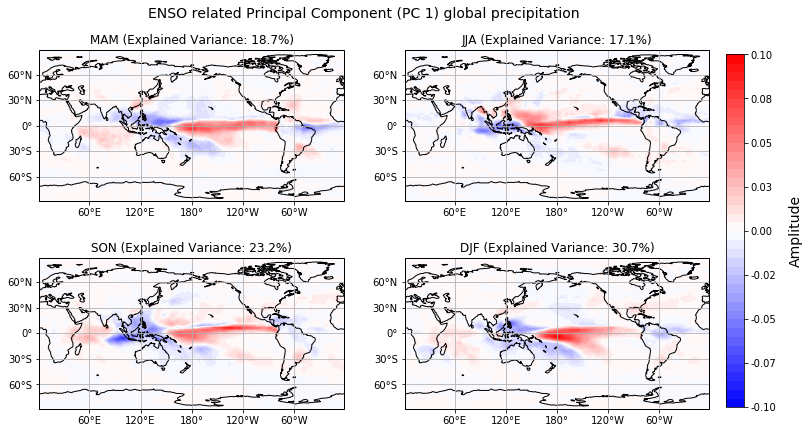

In [17]:
'''
   Plot of spatial variability map of leading principal 
   component of global precipitation.
'''

fig = plt.figure(figsize=(12,7))

#titles for subplots
season_name = ['MAM','JJA','SON','DJF']
#used to set cbarticks for contour plot
cbarticks = np.arange(-0.1,0.105,0.005) 
lon2d, lat2d = np.meshgrid(GPCPlons,GPCPlats)
title_name = "ENSO related Principal Component (PC 1) global precipitation"

for season in range(4):
    idx_subplot = season + 1
    #must use central_lon at equator to make map cross from MC to CP/EP region
    ax = fig.add_subplot(2,2,idx_subplot,
                         projection=ccrs.PlateCarree(central_longitude=180.0)) 

    plt.set_cmap('bwr')
    ax.coastlines(resolution='110m')
    ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                 ylocs = [-90,-60,-30,0,30,60,90], xlocs=[0,60,120,180,240,300,360])

    #remove gridline labels from top and right side of plots
    ax.xlabels_top = False
    ax.xlabels_bottom = True
    ax.ylabels_left = True
    ax.ylabels_right = False
    #Prints out latitude and longitude with proper coordinate system
    ax.set_xticks([60,120,180,-120,-60], crs = ccrs.PlateCarree())
    ax.set_yticks([-60,-30,0,30,60], crs = ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    shading=ax.contourf(lon2d,lat2d,GPCP_global_pc_maps[season,0,:,:],cbarticks,
                        transform=ccrs.PlateCarree())
    plt.title("%s %s %.1f%s" % (season_name[season],
                                "(Explained Variance:",100*GPCP_global_pc_expv[season,0],"%)"))

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #input: left, bottom, width, height
cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8,format ='%.2f')
cbarlabel = fig.text(1, 0.5, 'Amplitude', ha='center',
                     va='center',rotation='vertical', fontsize = 14)
header = fig.text(0.5,0.93,title_name, ha='center', va='center',fontsize = 14)

In [18]:
'''
   Correlation of leading PC time series for ERSST global
   and GPCP global to demonstrate that ENSO is the leading 
   mode of climate variability.
   
   ENSO events typically develop in JJA/SON, are fully mature 
   in DJF and decay in MAM.
   
   Note: PC sign is arbitrary.
'''
season_names = ['MAM','JJA','SON','DJF']
print('Correlation PC 1 ERSST global and GPCP global')
for season in range(4):
    print(season_names[season],':',np.round(np.corrcoef(sst_gpcp_len_global_pcTS[season,:,0],
                                                        GPCP_global_pcTS[season,:,0])[0,1],3))

Correlation PC 1 ERSST global and GPCP global
MAM : 0.777
JJA : -0.143
SON : -0.301
DJF : 0.924


In [19]:
'''
   Side note:
   
   There is another flavor of ENSO that has garnered attention 
   in the recent decades. The prevalent form of ENSO (shown above) 
   is called Eastern Pacific ENSO (EP ENSO). However, the second leading 
   mode of SST variability in the tropical Pacific region (not in global)
   displays the Central Pacific ENSO (CP ENSO) SST pattern, which is highlighted
   by positive SST anomalies near the dateline and negative SST anomalies on
   the western coast of South America. It is also known as ENSO Modoki 
   from Ashok et al. 2007. The fact that it does not appear in the global SST
   PC 2 is worth mentioning since it is not the second leading mode of global
   SST climate variability.
   
   The Nino Difference Index is intended to monitor EP ENSO, like the Oceanic
   Nino Index. This is what I focused on for the box search process.  
   However, I wanted to do a quick overview of CP ENSO. I am currently 
   researching the relationship of the Trans Nino Index (TNI), which is used 
   to monitor CP ENSO events, with the final NDI options.
'''

#Tropical Pacific SSTs lat and lon range
latr = SSTll.latr(-20,20) 
lonr = SSTll.lonr(90,-80)
#start year index for ERSST for GPCP length
syear_idx = GPCPdtime[0].year - SSTdtime[0].year

sst_tpac = SST4[:,syear_idx:,latr[0]:latr[1],lonr[0]:lonr[1]]
sst_tpac_pca = EOFanalysis(sst_tpac,nyears_gpcp)
sst_tpac_pc_expv = sst_tpac_pca[0]
sst_tpac_pcTS = sst_tpac_pca[2]
sst_tpac_pc_maps = sst_tpac_pca[3]
sst_tpac_pc_maps = sst_tpac_pc_maps.reshape(4,4,latr[1]-latr[0],
                                                lonr[1]-lonr[0])

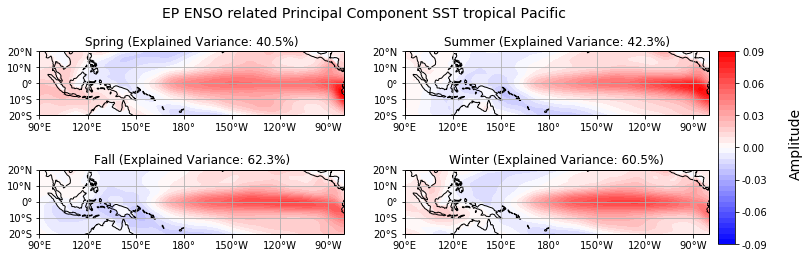

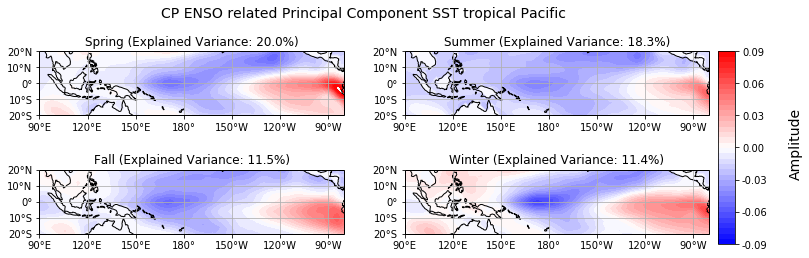

In [20]:
#Tropical Pacific SSTs lat and lon range
latr = SSTll.latr(20,-20) 
lonr = SSTll.lonr(90,-80)
#titles for subplots
season_name = ['Spring','Summer','Fall','Winter']
cbarticks = np.round(np.arange(-0.09,0.095,0.005),3) 
lon2d, lat2d = np.meshgrid(SSTlons[lonr[0]:lonr[1]], SSTlats[latr[0]:latr[1]])
title_name = ["EP ENSO related Principal Component SST tropical Pacific",
              "CP ENSO related Principal Component SST tropical Pacific"]

for pc_type in range(2):
    fig = plt.figure(figsize=(12,4))
    for season in range(4):
        idx_subplot = season + 1
        #must use central_lon at equator to make map cross from MC to CP/EP region
        ax = fig.add_subplot(2,2,idx_subplot,
                             projection=ccrs.PlateCarree(central_longitude=180.0)) 

        plt.set_cmap('bwr')
        ax.coastlines(resolution='110m')
        #ax.gridlines()
        ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False, 
                 ylocs = [-20,-10,0,10,20], xlocs=[90,120,150,180,210,240,270,280])

        #remove gridline labels from top and right side of plots
        ax.xlabels_top = False
        ax.xlabels_bottom = True
        ax.ylabels_left = True
        ax.ylabels_right = False
        ax.set_xticks([90,120,150,180,-150,-120,-90], crs = ccrs.PlateCarree())
        ax.set_yticks([-20,-10,0,10,20], crs = ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        shading=ax.contourf(lon2d,lat2d,sst_tpac_pc_maps[season,pc_type,:,:],cbarticks,
                            transform=ccrs.PlateCarree())
        plt.title("%s %s %.1f%s" % (season_name[season],
                                    "(Explained Variance:",100*sst_tpac_pc_expv[season,pc_type],"%)"))

    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.67]) #input: left, bottom, width, height
    cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8,format ='%.2f')
    cbar.set_ticks(np.arange(-0.09,0.12,0.03))
    cbarlabel = fig.text(1, 0.5, 'Amplitude', ha='center',
                         va='center',rotation='vertical', fontsize = 14)
    header = fig.text(0.5,0.95,title_name[pc_type], ha='center', va='center',fontsize = 14)

In [21]:
'''
   Displays that the CP ENSO signature is within PC 2
   of SST tropical Pacific and that it has a strong
   corelation to tropical precipitation PC 2 in SON
   and DJF, when ENSO events are close to/fully mature.
'''

season_names = ['MAM','JJA','SON','DJF']

for pc_type in range(2):
    if pc_type == 0:
        print('Correlation of SST tropical Pacific PC 1 (related to EP ENSO) and GPCP tropical PC 1','\n')
    else:
        print('Correlation of SST tropical Pacific PC 2 (related to CP ENSO) and GPCP tropical PC 2','\n')
    for season in range(4):
        print(season_names[season],':',np.round(np.corrcoef(sst_tpac_pcTS[season,:,pc_type],
                                                            GPCPtrop_pcTS[season,:,pc_type])[0,1],3))
    if pc_type == 0:
        print('\n')
    else:
        continue

Correlation of SST tropical Pacific PC 1 (related to EP ENSO) and GPCP tropical PC 1 

MAM : 0.72
JJA : 0.808
SON : 0.947
DJF : 0.934


Correlation of SST tropical Pacific PC 2 (related to CP ENSO) and GPCP tropical PC 2 

MAM : 0.539
JJA : 0.242
SON : 0.675
DJF : 0.84


In [22]:
'''
   Use correlation of ONI with global precipitation PC 1
   to tailor correlation threshold for search.
'''

#Load my calculated ONI data
rootpath = str("C:\\Users\\Owner")
dir_path_oni = rootpath + str("\\Documents\\python_dir\\ENSO\\ENSO_indices")
filename_oni = dir_path_oni + str("\\oni_ersst_j1892_f2021.npy")
my_oni_vec = np.load(filename_oni)

In [23]:
'''
   Trim zeros at end of array that correspond to
   2021 values that are not calculated.
'''
my_oni_vec_trim = my_oni_vec[:-10]

In [24]:
'''
   Find index for beginning of calculations using 
   my ONI
'''
syear_ersst = SSTdtime[0].year
syear_my_oni = 1892
my_oni_idx_beg = (1892-syear_ersst)*12
my_oni_idx_beg_check = SSTdtime[my_oni_idx_beg]
print(my_oni_idx_beg_check)

syear_gpcp = GPCPdtime[0].year
gpcp_idx_beg = (syear_gpcp-syear_ersst)*12
gpcp_idx_beg_check = SSTdtime[gpcp_idx_beg]
print(gpcp_idx_beg_check)

idx_start_calcs = gpcp_idx_beg - my_oni_idx_beg

1892-01-01 00:00:00
1979-01-01 00:00:00


In [25]:
'''
   Correlate GPCP global PC 1 with proper
   three year running mean below, use these
   values to select a proper correlation
   threshold in box search.
'''
season_name = ['MAM','JJA','SON','DJF']
print('Correlation ONI and GPCP PC 1')
for season in range(4):
    #since idx_start_calcs starts at 1979-01-01,
    #(DJF 1979 for ONI data), add 3 and multiply
    #by season to extract annual ONI values
    #that match length of GPCP.
    #(MAM 1979->MAM 2020 ONI w/ MAM PC 1 and 
    #DJF 1980->DJF 2021 ONI w/ DJF PC 1)
    idx = 3 + 3*season + idx_start_calcs
    print(season_name[season],':',np.round(np.corrcoef(my_oni_vec_trim[idx::12],
                                                       GPCP_global_pcTS[season,:,0])[0,1],3))

Correlation ONI and GPCP PC 1
MAM : 0.832
JJA : 0.896
SON : 0.936
DJF : 0.957


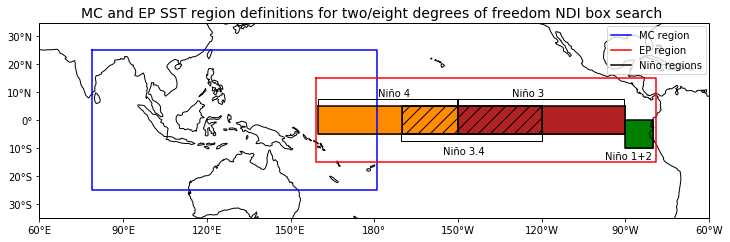

In [26]:
'''
   Plot MC/EP region search definitions and Niño box regions.
'''
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1,
                     projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines(resolution='110m')

#Note: ax.set_extent uses longitude values that
#go from 0->360 ("°E")
#set cartopy bounds to be 60°E and 60°W
ax.set_extent([60,300,-35,35], crs=ccrs.PlateCarree())
#Latitude (Longitude) labels on left (bottom) of figure
ax.xlabels_top = False
ax.xlabels_bottom = True
ax.ylabels_left = True
ax.ylabels_right = False
ax.set_xticks([60,90,120,150,180,-150,-120,-90,-60], crs = ccrs.PlateCarree())
ax.set_yticks([-30,-20,-10,0,10,20,30], crs = ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


'''
   Draw Maritime Continent (MC) and EP region bounds 
   for two and eight degree of freedom search.
   
   MC region: 
   79°E-179°W,25°S-25°N 
   (grid points 80°E to 180°,24°S-24°N )
   
   EP region:
   159°E-80°W,15°S-15°N
'''
#plot coordinates in terms of distance (°) from 180°
mcreg_lons = [-101,1,1,-101,-101]
mcreg_lats = [25,25,-25,-25,25]
mcreg = ax.plot(mcreg_lons,mcreg_lats,color='b',linestyle = 'solid',
               label='MC region')

epreg_lons = [-21,101,101,-21,-21]
epreg_lats = [15,15,-15,-15,15]
epreg = ax.plot(epreg_lons,epreg_lats,color='r',linestyle='solid',
               label='EP region')

'''Draw Niño 3 box: 5°N-5°S,150°W-90°W'''
nino3_lons = [90,30,30,90,90]
nino3_lats = [5,5,-5,-5,5]
#label these to denote rest of box plotted
nino3 = ax.plot(nino3_lons,nino3_lats,color='k',
                linestyle = 'solid',label = 'Niño regions')
#shading (Note: shading definition follows different coordinate
#system). Used add_patch function because add_geometries
#does not have fill or no fill option with my current version

##geom = geometry.box(minx=-150,maxx=-90,miny=-5,maxy=5)
##shading = ax.add_geometries([geom],crs=ccrs.PlateCarree(),
##                            color='firebrick',alpha=0.75)


#add braces to denote region for text
#slightly adjust region bounds to make braces
#fit on plotted box region
nino3_brace_lons = [89.5,89.5,29.5,29.5]
nino3_brace_lats = [5,7.5,7.5,5]
nino3_brace = ax.plot(nino3_brace_lons,nino3_brace_lats,color='k',
                       linestyle = 'solid',linewidth=1)

ax.add_patch(Rectangle((30,-5),60,10,color='firebrick'))

#add labels for the Nino 3 region
label = ax.text(55, 8.5, 'Niño 3',
               horizontalalignment='center',fontsize=10)

'''Niño 4 region: 5°N-5°S,160°E-150°W'''
nino4_lons = [-20,30,30,-20,-20]
nino4_lats = [5,5,-5,-5,5]
nino4 = ax.plot(nino4_lons,nino4_lats,color='k',linestyle = 'solid')

nino4_brace_lons = [-20,-20,30,30]
nino4_brace_lats = [5,7.5,7.5,5]
nino4_brace = ax.plot(nino4_brace_lons,nino4_brace_lats,color='k',
                       linestyle = 'solid',linewidth=1)

label = ax.text(7,8.5,'Niño 4',
               horizontalalignment='center',fontsize=10)
shading = ax.add_patch(Rectangle((-20,-5),50,10,color='darkorange'))

'''Niño 3.4 region: 5°N-5°S,170°W-120°W'''
nino34_lons = [60,10,10,60,60]
nino34_lats = [5,5,-5,-5,5]
nino34 = ax.plot(nino34_lons,nino34_lats,color='k',linestyle = 'solid')

nino34_brace_lons = [60,60,9.5,9.5]
nino34_brace_lats = [-5,-7.5,-7.5,-5]
nino34_brace = ax.plot(nino34_brace_lons,nino34_brace_lats,color='k',
                       linestyle = 'solid',linewidth=1)

ax.add_patch(Rectangle((10, -5), 50, 10,color="k",fill=False,hatch='//'))

label = ax.text(32,-12, 'Niño 3.4',
               horizontalalignment='center',fontsize=10)

'''Niño 1+2 region: 0°N-10°S,90°W-80°W'''
nino12_lons = [90,100,100,90,90]
nino12_lats = [0,0,-10,-10,0]
nino12 = ax.plot(nino12_lons,nino12_lats,color='k',linestyle = 'solid')

#nino12_brace_lons = [60,60,9.5,9.5]
#nino34_brace_lats = [-5,-7.5,-7.5,-5]
#nino34_brace = ax.plot(nino34_brace_lons,nino34_brace_lats,color='k',
#                       linestyle = 'solid',linewidth=1)

ax.add_patch(Rectangle((90, -10), 10, 10,color="green"))
label = ax.text(91,-14, 'Niño 1+2',
               horizontalalignment='center',fontsize=10)

'''Plotting title and figure legend'''

title_fig = 'MC and EP SST region definitions for two/eight degrees of freedom NDI box search'
header = fig.text(0.51,0.75,title_fig, ha='center', va='center',fontsize = 14)

leg = ax.legend(bbox_to_anchor =(0.84, 0.71),fontsize = 10)

In [27]:
'''
   First Nino Difference Index search method:
   Use full eight degrees of freedom: EP/MC box width,
   height, latitude and longtidue box center location.
   Allow regions to overlap to fully fit longitude
   range of all Niño regions.
   
   EP = Eastern Pacific
   MC = Maritime Contient
   
   MC region definition:
   79°E-179°W,25°S-25°N
   (gridpoint index defintion: 80°E-180°,24°S-24°N)
       
   EP region definition:
   159E°-79°W,15°S-15°N
'''

'''Define boundaries for EP and MC regions'''

#Note: latitude values go from pos.
#to neg. (°N to °S).
mc_lat_bounds = SSTll.latr(-25,25)
mcreg_north = mc_lat_bounds[0]
mcreg_south = mc_lat_bounds[1]

#lon values go from °E to °W
mc_lon_bounds = SSTll.lonr(80,180)
mcreg_west = mc_lon_bounds[0]
mcreg_east = mc_lon_bounds[1]

ep_lat_bounds = SSTll.latr(-14,14)
epreg_north = ep_lat_bounds[0]
epreg_south = ep_lat_bounds[1]

ep_lon_bounds = SSTll.lonr(160,-80)
epreg_west = ep_lon_bounds[0]
epreg_east = ep_lon_bounds[1]

'''
   Define maximum and minimum allowed 1/2 heights/
   widths for each box. For this search, I will make 
   minimum MC box size to 5° by 5° and minimum EP box 
   size to be 18° lon by 5° lat (taking into account
   ERSST grid spacing-centered).
'''
#use in box size and NDI box 
#calculations
eph_min = 2
mch_min = 2
#use in for loop iterations
eph_min_loop = int(eph_min/2)
mch_min_loop = int(mch_min/2)

epw_min = 8
mcw_min = 2
epw_min_loop = int(epw_min/2)
mcw_min_loop = int(mcw_min/2)

In [28]:
'''
   Change latitude/longitude values for SST4 array 
   that are set to be zero that cover land areas to 
   NaN's for calculation of NDI options in index search.
'''
SST4_gpcp_len[SST4_gpcp_len == 0] = np.nan

In [29]:
'''
   Pre-setting MC/EP maximum allowed 1/2 heights in for
   loop based on the latitude/longitude index we are
   on. Convert to index values to use within for loop. 
'''

mch_max = np.zeros(mc_lat_bounds[1]-mc_lat_bounds[0])

for mclat in range(mc_lat_bounds[0],mc_lat_bounds[1]):
    idx = mclat - mc_lat_bounds[0]
    #determining maximum half height of box for
    #each MC latitude gridpoint index based on boundaries
    #of each box. Minumum height from each boundary.
    #Latitude gridpoints go from 90-> -90 in ERSST
    mclat_loop = SSTlats[mclat]
    mch_max1 = SSTlats[mcreg_north] - mclat_loop
    #Add 2 since mcreg_south indexes 26°S for
    #indexing in box time series calculations
    mch_max2 = abs(SSTlats[mcreg_south]+2) + mclat_loop
    mch_max_val = min(mch_max1,mch_max2)
    #limit MC height to 30° (north-suth extent)
    if mch_max_val < 15:
        mch_max[idx] = mch_max_val/2
    else:
        #grid point half height/grid point spacing
        mch_max[idx] = 14/2

#make array integers for indexing in below cells
mch_max = mch_max.astype(int)

mcw_max = np.zeros(mc_lon_bounds[1]-mc_lon_bounds[0],)
for mclon in range(mc_lon_bounds[0],mc_lon_bounds[1]):
    idx = mclon - mc_lon_bounds[0]
    mclon_loop = SSTlons[mclon]
    mcw_max1 = abs(SSTlons[mcreg_west] - mclon_loop)
    #Subtract 2 since mcreg_east indexes 282°E (-78°W)
    #in the calculation
    mcw_max2 = (SSTlons[mcreg_east]-2) - mclon_loop
    mcw_max_loop = int(min(mcw_max1,mcw_max2))
    mcw_max[idx] = int(mcw_max_loop/2)

mcw_max = mcw_max.astype(int)

eph_max = np.zeros(ep_lat_bounds[1]-ep_lat_bounds[0],)
for eplat in range(ep_lat_bounds[0],ep_lat_bounds[1]):
    idx = eplat - ep_lat_bounds[0]
    eplat_loop = SSTlats[eplat]
    eph_max1 = SSTlats[epreg_north] - eplat_loop
    eph_max2 = abs(SSTlats[epreg_south]+2) + eplat_loop
    eph_max_val = min(eph_max1,eph_max2)
    #limit EP height to 14° (north-south extent)
    if eph_max_val < 7:
        eph_max[idx] = eph_max_val/2
    else:
        eph_max[idx] = 6/2

eph_max = eph_max.astype(int)

epw_max = np.zeros(ep_lon_bounds[1]-ep_lon_bounds[0],)
for eplon in range(ep_lon_bounds[0],ep_lon_bounds[1]):
    idx = eplon - ep_lon_bounds[0]
    eplon_loop = SSTlons[eplon]
    epw_max1 = abs(SSTlons[epreg_west] - eplon_loop)
    epw_max2 = (SSTlons[epreg_east]-2) - eplon_loop
    epw_max_val = int(min(epw_max1,epw_max2))
    #limit EP box size to 70° (east-west extent)
    if epw_max_val < 35:
        epw_max[idx] = int(epw_max_val/2)
    else:
        epw_max[idx] = 34/2
        
epw_max = epw_max.astype(int)

In [30]:
'''
   Calculating all possible MC box options
   based on my MC region definition and
   constraints made below to maximum height
   and width. Reduces the amount of for loops 
   in below cell by 3 to increase computation 
   speed.
'''
for seasons in range(1):
    season = 3
    count = 0
    mc_count_djf = []
    mc_info_djf = []
    for mclat in range(mc_lat_bounds[0],mc_lat_bounds[1]):
        mclat_loop = SSTlats[mclat]
        idx = mclat - mc_lat_bounds[0]
        mch_max_loop = mch_max[idx]
        for mclon in range(mc_lon_bounds[0],mc_lon_bounds[1]):
            mclon_loop = SSTlons[mclon]
            idx = mclon - mc_lon_bounds[0]
            mcw_max_loop = mcw_max[idx]
            for mch in range(mch_min_loop,mch_max_loop+1):
                #adjust height since it based off of gridpoint
                #indexing
                mch_loop = mch*2
                #find southern/northern boundary of MC box
                #multiply by lat/lon grid spacing (2 degrees)
                #to find half height value
                mcbox_n = mclat_loop + mch_loop
                mcbox_s = mclat_loop - mch_loop
                mcbox_lat_inds = SSTll.latr(mcbox_s,mcbox_n)
              
                for mcw in range(mcw_min_loop,mcw_max_loop+1):
                    mcw_loop = mcw*2
                    #find eastern and eastern/boundary of MC box
                    mcbox_w = mclon_loop - mcw_loop
                    mcbox_e = mclon_loop + mcw_loop
                    mcbox_lon_inds = SSTll.lonr(mcbox_w,mcbox_e)
                    
                    mc_box_data = np.zeros((nyears_gpcp,))                                            
                    
                    for year in range(nyears_gpcp):
                        mc_box_data[year] = np.nanmean(SST4_gpcp_len[season,year,
                                                                     mcbox_lat_inds[0]:mcbox_lat_inds[1],
                                                                     mcbox_lon_inds[0]:mcbox_lon_inds[1]])
                    #omitting boxes that fully cover land regions
                    if math.isnan(mc_box_data[0]) == False:
                        count = count+1
                        mc_count_djf.append(count)
                        mc_info_djf.append([mclat_loop,mclon_loop,mch_loop,mcw_loop,mc_box_data])

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


In [31]:
'''
   Total number of MC box options.
'''
mc_box_count = np.asarray(mc_count_djf).shape[0]
print('Calculated amount of MC box options:',mc_box_count)

Calculated amount of MC box options: 74254


In [32]:
'''
   Verify that available amount of MC boxes options is correct.
   Hypothetically, it's available amount of gridpoint options
   in the MC region multiplied by the mean 1/2 height/width 
   options for all grid points in the region.
'''
mcreg_width = mcreg_east-mcreg_west
mcreg_height = mcreg_south-mcreg_north

mch_avg = np.round(np.mean(mch_max),0)
mcw_avg = np.round(np.mean(mcw_max),0)
print('Estimated amount of MC box options:',
      mcreg_width*mcreg_height*mch_avg*mcw_avg)

Estimated amount of MC box options: 76500.0


In [33]:
'''
   Calculating all possible EP box options to increase
   computation speed of all possible NDI combinations
   based on EP region size and constraints to height
   and width made below.
'''

for seasons in range(1):
    season = 3
    ep_info_djf = []
    ep_count_djf = []
    count = 0
    for eplat in range(ep_lat_bounds[0],ep_lat_bounds[1]):
        eplat_loop = SSTlats[eplat]
        idx = eplat - ep_lat_bounds[0]
        eph_max_loop = eph_max[idx]
            
        for eplon in range(ep_lon_bounds[0],ep_lon_bounds[1]):
            eplon_loop = SSTlons[eplon]
            idx = eplon - ep_lon_bounds[0]
            epw_max_loop = epw_max[idx]
            for eph in range(eph_min_loop,eph_max_loop+1):
                eph_loop = eph*2
                epbox_n = eplat_loop + eph_loop
                epbox_s = eplat_loop - eph_loop
                epbox_lat_inds = SSTll.latr(epbox_s,epbox_n)
                
                for epw in range(epw_min_loop,epw_max_loop+1):
                    epw_loop = epw*2
                    #find eastern and eastern/boundary of EP box
                    epbox_w = eplon_loop - epw_loop
                    epbox_e = eplon_loop + epw_loop
                    epbox_lon_inds = SSTll.lonr(epbox_w,epbox_e)
                    
                    ep_box_data = np.zeros(nyears_gpcp,)
                    for year in range(nyears_gpcp):
                        ep_box_data[year] = np.nanmean(SST4_gpcp_len[season,year,
                                                                     epbox_lat_inds[0]:epbox_lat_inds[1],
                                                                     epbox_lon_inds[0]:epbox_lon_inds[1]])
                    
                    if math.isnan(ep_box_data[0]) == False:
                        count = count+1
                        ep_count_djf.append(count)
                        ep_info_djf.append([eplat_loop,eplon_loop,eph_loop,epw_loop,ep_box_data])

In [34]:
'''
   Total number of EP boxes.
'''
ep_box_count = np.asarray(ep_count_djf).shape[0]
print('Calculated amount of EP box options:',ep_box_count)

Calculated amount of EP box options: 18480


In [35]:
'''
   Verify that available amount of EP boxes options is correct.
   
   Note: MC region estimate is close to being to correct. I
   double checked the method and it's the same as the MC box option 
   calculation. This is just an estimate and is likely affected
   by how wide the EP box is relative to how tall it is.
'''
epreg_width = epreg_east-epreg_west
epreg_height = epreg_south-epreg_north
eph_avg = np.mean(eph_max)
epw_avg = np.mean(epw_max)
print('Estimated amount of EP box options:',
      np.round(epreg_width*epreg_height*eph_avg*epw_avg,0))

Estimated amount of EP box options: 24123.0


In [37]:
'''
   Method to search for all possible NDI options, with no EP or 
   MC boxes that have overlapping longitude box boundaries.
   Correlate NDI options with PC 1 time series of Global 
   Precipitation. Here, I am only searching for DJF 
   (index = 3 in seasonal SST and global preciptation PC time 
   series). I can split up the loops because in the eight degrees
   of freedom method each EP box has to be calculated with all
   possible MC boxes.
   
   Also, MC and EP box height and widths are calculated at 4° intervals 
   since I am adding/subtracting by 1/2 heights corresponding to gridpoint
   height (e.g. for 2° 1/2 height, calcalutes 4° grid point height. Then, 
   for 4° 1/2 height it calculates 8° height and so on if that height can 
   be calculated based on region definition). It skips 6°/10° height boxes, 
   which would correspond to an actual box height/width of 14°. Best option 
   is to re-run using same method except for calculating for those omitted 
   heights/widths instead of the others, but with the amount of options
   searched this should be satisfactory.
   
   **Strategy for analysis**
   
   Set correlation threshold to 0.9 for SON/DJF seasons, 0.85 in JJA, and 0.8
   in MAM using ONI seasonal correlations with GPCP global PC 1 as a baseline.
   Also, only look for positive NDI correlations with GPCP global PC 1
   since we want NDI options to have the same sign as the ONI, with strong El
   Niño events signifying a warmer EP SST region and cooler MC SST region and
   vice-versa for strong La Niña events. This will filter the ~1.35 billion 
   possible NDI box combinations in this search to evaluate the ones that have 
   the strongest relationship with the ENSO driven atmospheric response.
   
   **For demonstration purposes**
   
   Since this is so computationally expensive, I will only calculate for
   the first 200 EP box options. I may also adjust minimum and maximum
   allowed 1/2 heights to reduce the number of options. This looks to be 
   a good situation to use pytorch for in-loop calculations of the NDI 
   and correlation to speed up the computation speed, I will look at that 
   in the near future since I am re-visiting this search method in my 
   post-graduate ENSO research as a volunteer. Here, I will set the 
   correlation threshold to be 0.2 to verify NDI options are being 
   calculated and stored correctly in the below cells. 
   
   Loop takes ~15 minutes to go through 200 of 18,480 iterations
   for each EP box (14.5 million box combinations) using numpy.
'''
start_time = dt.datetime.now()
for seasons in range(1):
    ndi_info_djf = []
    season = 3
    for epboxes in range(200):
        #keeping track of for loop progress
        if epboxes % 25 == 0 or epboxes == 199:
            time_check = dt.datetime.now()
            print(time_check-start_time)
  
        eplat = ep_info_djf[epboxes][0]
        eplon = ep_info_djf[epboxes][1]
        eph = ep_info_djf[epboxes][2]
        epw = ep_info_djf[epboxes][3]
        ep_west = eplon - epw
        ep_box_data = ep_info_djf[epboxes][4]
        
        for mcboxes in range(mc_box_count):
            #first check if MC and EP boxes
            #touch/overlap and omit those box
            #combinations
            mclon = mc_info_djf[mcboxes][1]
            mcw = mc_info_djf[mcboxes][3]
            mc_east = mclon + mcw
            #set correlation to zero
            corr = 0
            if mc_east < ep_west:
                mclat = mc_info_djf[mcboxes][0]
                mch = mc_info_djf[mcboxes][2]
                mc_box_data = mc_info_djf[mcboxes][4]
                #calculate NDI (EP - MC)
                NDI = ep_box_data - mc_box_data
                #calculation correlation of NDI option with GPCP global PC 1
                corr = np.round(np.corrcoef(NDI,GPCP_global_pcTS[season,:,0])[0,1],3)
            else:
                continue
            #print values to save
            #Also, omit NDI options that have overlapping/
            #touching box boundaries
            if corr >= 0.2:
                ndi_info_djf.append([mclat,mclon,mch,mcw,eplat,eplon,eph,epw,corr])
            else:
                continue

0:00:00
0:01:30.124183
0:03:10.574932
0:04:55.381235
0:06:46.344363
0:08:39.783076
0:10:40.433445
0:12:41.473861
0:14:44.931234


In [38]:
'''Check to make sure calculations were done correctly'''
#MC (then EP) lat,lon,height,width, correlation
ndi_info_djf[100]

[16.0, 140.0, 2, 6, 12.0, 168.0, 2, 8, 0.333]

In [39]:
#convert each idx to an integer for use in for loop
#Also, add one for south and east indices since lonr 
#and latr stores the following index to properly 
#retrieve the right values for box calculations
mclat_s_test = int(np.where(SSTlats == 16-2)[0]) + 1
mclat_n_test = int(np.where(SSTlats == 16+2)[0])
mclon_w_test = int(np.where(SSTlons == 140-6)[0])
mclon_e_test = int(np.where(SSTlons == 140+6)[0]) + 1

eplat_s_test = int(np.where(SSTlats == 12-2)[0]) + 1
eplat_n_test = int(np.where(SSTlats == 12+2)[0])
eplon_w_test = int(np.where(SSTlons == 168-8)[0])
eplon_e_test = int(np.where(SSTlons == 168+8)[0]) + 1

test_mc = np.zeros((nyears_gpcp,))
test_ep = np.zeros((nyears_gpcp,))
for year in range(nyears_gpcp):
    test_mc[year] = np.nanmean(SST4_gpcp_len[3,year,mclat_n_test:mclat_s_test,
                                             mclon_w_test:mclon_e_test])
    test_ep[year] = np.nanmean(SST4_gpcp_len[3,year,eplat_n_test:eplat_s_test,
                                             eplon_w_test:eplon_e_test])

test_ndi = test_ep-test_mc
    
print(np.round(np.corrcoef(test_ndi,GPCP_global_pcTS[3,:,0])[0,1],3))

0.333


In [40]:
''' 
   Method 2: 
   
   Two degrees of freedom search. Constrain EP width, height, latitude and longtiude
   box center and MC height and width by holding box size constant. 
   Use Niño 3.4 SST box since that is arguably the optimal SST box to monitor ENSO 
   (Used by NOAA for the Oceanic Niño Index). Method used to select the recommended 
   NDI options in my thesis.
    
   Step 1: 
   
   Linear regression of leading recipitation PCs (ropical, northern hemisphere, and 
   global precipitation. Seasonal Niño 3.4 SSTs is the predictor and the leading 
   precipitation PC is the predictand. Then, calculate the "residuals", which is the
   component of the leading precipitation PC time series that is uncorrelated with Nino 3.4 
   SSTs (y_regressed - y_original).
'''

#Load my monthly Nino 3.4 adjusted SST values that match exact size of Nino 3.4 box
#from ERSST dataset for linear regression calculations
rootpath = str("C:\\Users\\Owner")
dir_path_sst_monthly = rootpath + str("\\Documents\\python_dir\\ENSO\\nino_box_info")
filename_nino3pt4monthly = dir_path_sst_monthly + str("\\nino3pt4monthly_j1854_oct2021.npy")
nino3pt4monthly = np.load(filename_nino3pt4monthly)

#check to confirm Nino 3.4 monthly and ERSST data ar same length
print(nino3pt4monthly.shape[0],SST.shape[0])

2014 2014


In [41]:
'''Find seasonal averages for Niño 3.4 SST box
   for calculations using linear regression
   method. Calculates up to DJF 2021.
'''

nino3pt4Season = np.zeros((4,SSTnyears))
for season in range(4):
    for years in range(SSTnyears):
        ym = 2 + 3*season + years*12
        nino3pt4Season[season,years] = np.mean(nino3pt4monthly[ym:ym+3])

In [42]:
'''
   Linear regression of Niño 3.4 region SSTs
   with three leading PCs of precipitation.
'''

syear_nino34 = GPCPdtime[0].year - SSTdtime[0].year

gpcp_global_pcaTS_linreg = np.zeros((nyears_gpcp,4))
GPCPtrop_pcTS_linreg = np.zeros((nyears_gpcp,4))

#precip leading pc residuals,seasons,length of gpcp
#PC[0,:,:] = GPCP global PC 1 residuals
#PC[1,:,:] = GPCP tropical PC 1 residuals
#PC[2,:,:] = GPCP extratropical PC 1 residuals
residuals_precip_pcs = np.zeros((3,4,nyears_gpcp))

#X(predictor) = Nino 3.4 SSTs and Y (Predictand) is GPCP Global PC 1  (y = m*x + b)
for pc_type in range(3):
    if pc_type == 0:
        precip_pc = GPCP_global_pcTS
    elif pc_type == 1:
        precip_pc = GPCPtrop_pcTS
    else:
        precip_pc = GPCP_nhp_pcTS
        
    for season in range(4):
        #Tropical Precipitation PC 1
        model = LinearRegression().fit(nino3pt4Season[season,syear_nino34:].reshape(-1,1),
                                       precip_pc[season,:,0])
        #Equation to calculate GPCP Trop. PC 1 residuals (finds y = mx + b relationship for data)
        #where y is GPCP tropical PC 1 regressed values
        GPCP_pcTS_linreg = model.intercept_ + model.coef_*nino3pt4Season[season,syear_nino34:]
        #Calculate residauls (original PC 1 timeseries - regressed PC 1 timeseries)
        residuals_precip_pcs[pc_type,season,:] = precip_pc[season,:,0] - GPCP_pcTS_linreg

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: Mean of empty slice


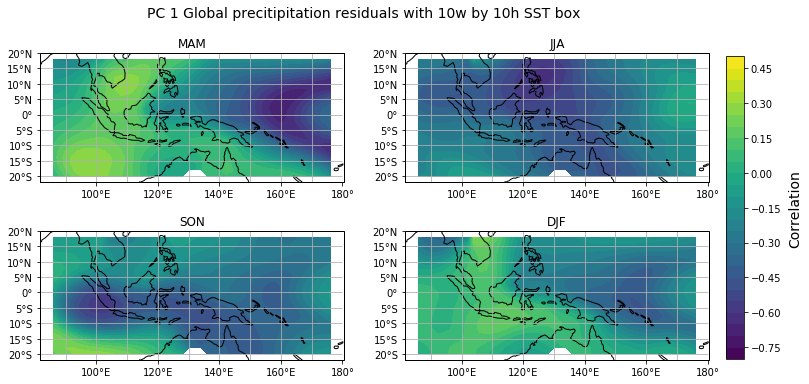

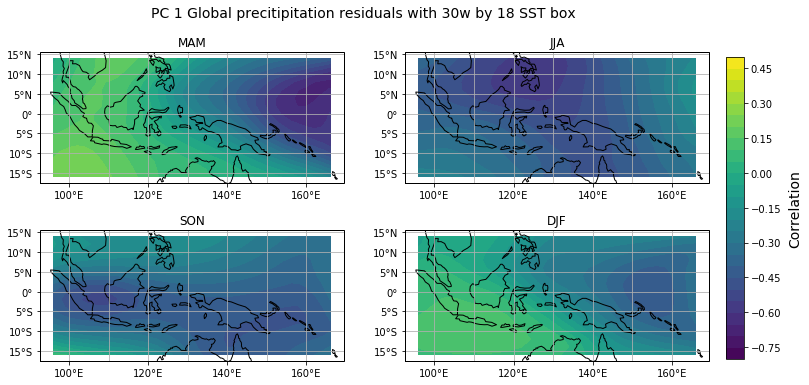

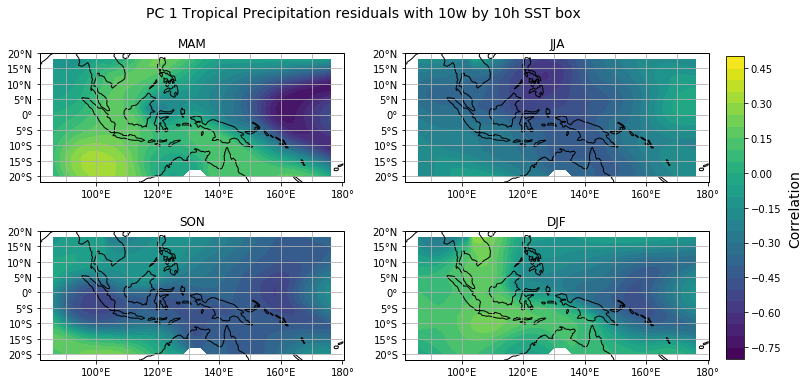

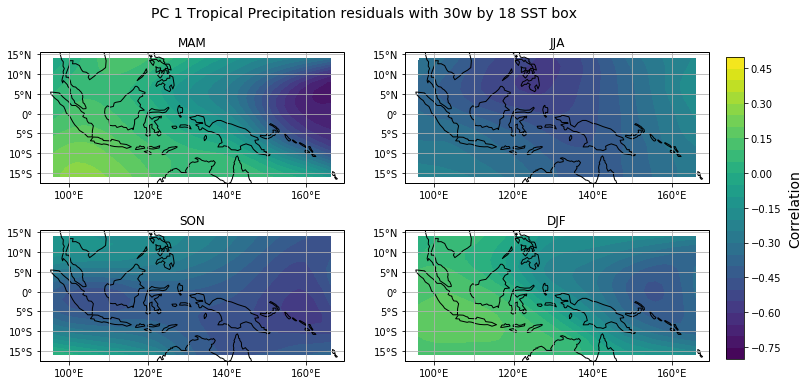

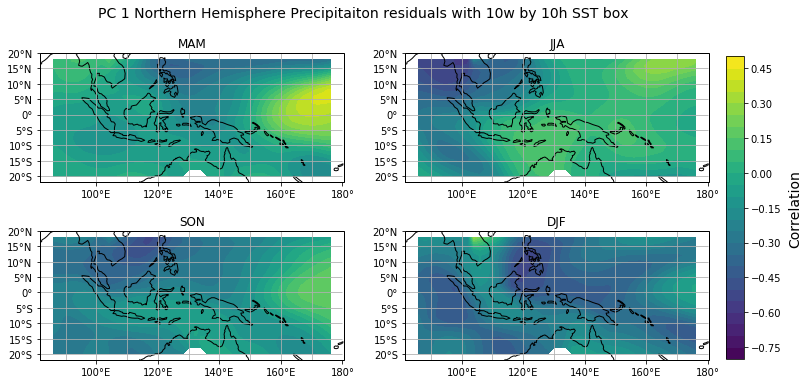

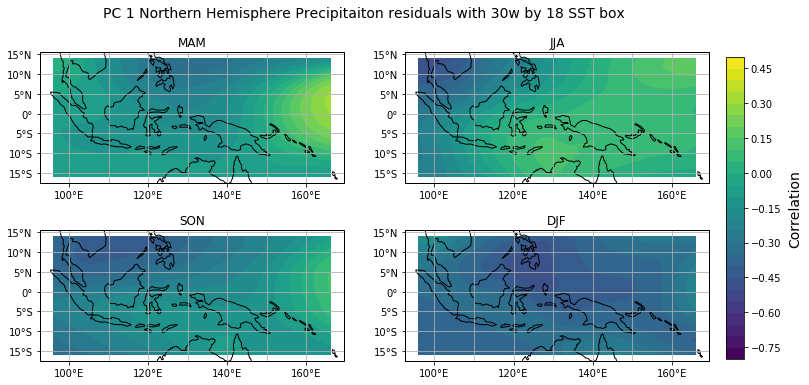

In [43]:
'''
    Correlation between GPCP PC 1 residuals and SSTs in MC region for 
    MC box width of 10w by 10h and 30w by 18h. In my thesis for the
    box search, I also included boxes with different dimensions
    (18w by 30h, 60w by 30h and 30w by 10h and 10w by 30h) and one
    more PC type (extra-tropical precipitation). I'm only
    including the MC box sizes that lead to the selection of final
    recommended NDI options in my thesis to demonstrate the 
    method.
    
    Definition of MC region: 
    80°E to 180°E, 25°S to 25°N (Same as eight degrees of freedom search)
    
    Plotted:
    Contourf of precipitation PC 1 and MC box option correlations 
    for each center grid point.
    For MC box grid point at 0°,170°E with 10w by 10h size, box coordinates 
    would be 5°S-5°N, 165°-175°E since grid spacing is 2° by 2° for ERSST
    with centered grid points.
    
    Looking for regions with strong negative correlations to look
    MC box options that have the opposite sign of EP box (and hence will
    add information to the Niño 3.4 SST box. 
'''

mcreg_size_latr = SSTll.latr(25,-25) 
mcreg_size_lonr = SSTll.lonr(80,180)

#Edges of MC region to use in for loop
mcreg_lat_n = SSTlats[mcreg_size_latr[0]]
mcreg_lat_s = SSTlats[mcreg_size_latr[1]]

mcreg_lon_w = SSTlons[mcreg_size_lonr[0]]
mcreg_lon_e = SSTlons[mcreg_size_lonr[1]]

#meshgrid to contour values in loop
lon2d, lat2d = np.meshgrid(SSTlons[mcreg_size_lonr[0]:mcreg_size_lonr[1]], 
                           SSTlats[mcreg_size_latr[0]:mcreg_size_latr[1]])

#1/2 heights and widths that match
#gridpoint spacing. using SSTll.latr/lonr
#properly indexes the array to get
#correct box heights desired.

#Row 0 is for 10w by 10h box
#Row 1 is for 30w by 18h box
mcw = [4,14]
mch = [4,8]

cbarticks = np.arange(-0.8,0.55,0.05)

title_pc = ['PC 1 Global precitipitation residuals with',
            'PC 1 Tropical Precipitation residuals with',
            'PC 1 Northern Hemisphere Precipitaiton residuals with']

title_box = ['10w by 10h SST box','30w by 18 SST box']
season_name = ['MAM','JJA','SON','DJF']

for pc_type in range(3):
    for boxsize in range(2):
        fig = plt.figure(figsize=(12,6))
        c = np.zeros((mcreg_size_latr[1]-mcreg_size_latr[0],mcreg_size_lonr[1]-mcreg_size_lonr[0]))
        for season in range(4):    
            idx_subplot = season + 1
            ax = fig.add_subplot(2,2,idx_subplot,
                                 projection=ccrs.PlateCarree(central_longitude=-180))
            plt.set_cmap('viridis')
            ax.coastlines(resolution='110m')
            ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                         ylocs = [-25,-20,-15,-10,-5,0,5,10,15,20,25], 
                         xlocs=[80,90,100,110,120,130,140,150,160,170,180])

            #remove gridline labels from top and right side of plots
            ax.xlabels_top = False
            ax.xlabels_bottom = True
            ax.ylabels_left = True
            ax.ylabels_right = False
            #Prints out latitude and longitude with proper coordinate system
            ax.set_xticks([80,100,120,140,160,180], crs = ccrs.PlateCarree())
            ax.set_yticks([-25,-20,-15,-10,-5,0,5,10,15,20,25], crs = ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter()
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
            #subtract two 
            for ilat in range(mcreg_size_latr[0],mcreg_size_latr[1]):
                mcbox_lat_center = SSTlats[ilat]
                mcbox_n = int(mcbox_lat_center + mch[boxsize])
                mcbox_s = int(mcbox_lat_center - mch[boxsize])
            
                mcbox_latr = SSTll.latr(mcbox_n,mcbox_s)
            
                #Conditions to make sure MC box edges to not extend past the MC region size.
                #Does if condition 1 or 2 equals 0.
                #Since latr and lonr indexes south and west edge that's one grid point past
                #the box size for calculations with indexing for python (because python 
                #indexing starts at zero), make adjustment in if/else statement to 
                #account for box we are calculating.
                if SSTlats[mcbox_latr[0]] >= mcreg_lat_n or SSTlats[mcbox_latr[1]-1] <= mcreg_lat_s:
                    cond1 = 0
                else:
                    cond1 = 1
                
                for ilon in range(mcreg_size_lonr[0],mcreg_size_lonr[1]):                
                    mcbox_lon_center = SSTlons[ilon]
                
                    mcbox_w = int(mcbox_lon_center - mcw[boxsize])
                    mcbox_e = int(mcbox_lon_center + mcw[boxsize])
                    mcbox_lonr = SSTll.lonr(mcbox_w,mcbox_e)
                
                    #Note:
                    if SSTlons[mcbox_lonr[0]] <= mcreg_lon_w or SSTlons[mcbox_lonr[1]-1] >= mcreg_lon_e:
                        cond2 = 0
                    else:
                        cond2 = 1

                    
                    SSTbox = SST4_gpcp_len[season,:,mcbox_latr[0]:mcbox_latr[1],mcbox_lonr[0]:mcbox_lonr[1]]
                    SSTbox_reshape = SSTbox.reshape(SSTbox.shape[0],SSTbox.shape[1]*SSTbox.shape[2]) #reshape to take mean
                    SSTbox_mean = np.nanmean(SSTbox_reshape, axis = 1) #SST box time series for each box (for indiv. season)
                    #1st and 2nd if/else statment make correlation nan if MC box
                    #timeseries is NaN (no SST values) or if calculated MC box
                    #edges exceed the boundaries of the MC region
                    if math.isnan(SSTbox_mean[0]) == True:
                        c[ilat-mcreg_size_latr[0],ilon-mcreg_size_lonr[0]] = np.nan
                    elif cond1 == 0 or cond2 == 0:
                        c[ilat-mcreg_size_latr[0],ilon-mcreg_size_lonr[0]] = np.nan
                    else:
                        corr_loop = np.corrcoef(SSTbox_mean,residuals_precip_pcs[pc_type,season,:])[0,1] 
                        c[ilat-mcreg_size_latr[0],ilon-mcreg_size_lonr[0]] = corr_loop
                    
            shading=ax.contourf(lon2d,lat2d,c,cbarticks,
                                transform=ccrs.PlateCarree())
            plt.title(season_name[season])
    
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) #input: left, bottom, width, height
        cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8)
        cbarlabel = fig.text(1, 0.5, 'Correlation', ha='center',
                             va='center',rotation='vertical', fontsize = 14)
        title_plot = title_pc[pc_type],' ',title_box[boxsize]
        header = fig.text(0.5,0.95,("%s %s" % (title_pc[pc_type],title_box[boxsize])),
                                    ha='center', va='center',fontsize = 14)


In [44]:
'''
   Correlation of northern hemisphere, tropical, and global precipitation PC 1.
   Displaying that global and tropical precipitation PC 1 are strongly related,
   and why the results for the two degrees of freedom method using those two
   leading PC's are very similar. Conversely, why Northern Hemisphere Precipitation
   precipitation two degrees of freedom search method look different.
'''

season_names = ['MAM:','JJA:','SON:','DJF:']
print('Correlation of global and tropical precipitation PC 1')
for season in range(4):
    print(season_names[season],np.round(np.corrcoef(GPCP_global_pcTS[season,:,0],
                                        GPCPtrop_pcTS[season,:,0])[0,1],3))

print('\n')
print('Correlation of global and northern hemisphere precipitation PC 1')
for season in range(4):
    print(season_names[season],np.round(np.corrcoef(GPCP_global_pcTS[season,:,0],
                                        GPCP_nhp_pcTS[season,:,0])[0,1],3))

Correlation of global and tropical precipitation PC 1
MAM: 0.923
JJA: 0.995
SON: 0.997
DJF: 0.998


Correlation of global and northern hemisphere precipitation PC 1
MAM: 0.274
JJA: -0.233
SON: 0.577
DJF: 0.871


C:\Users\Owner\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


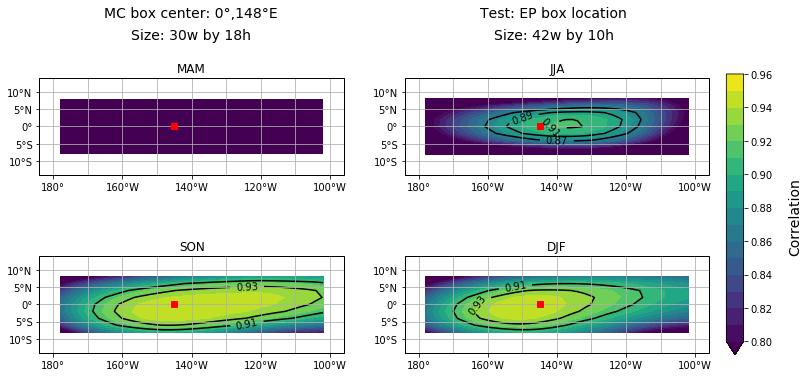

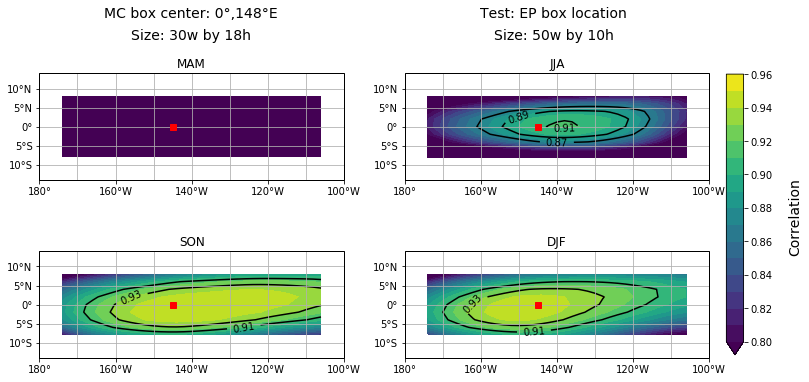

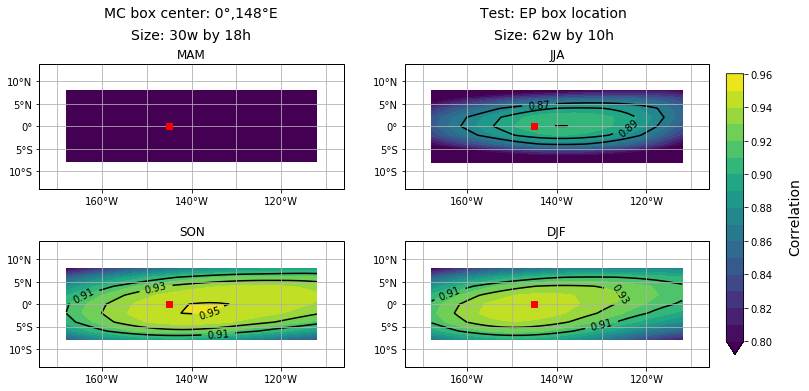

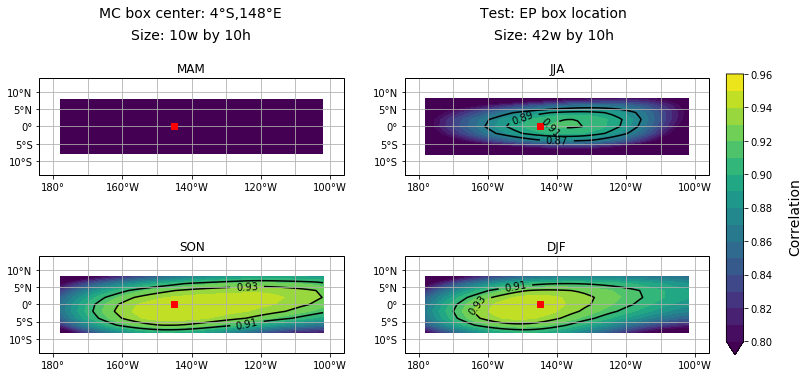

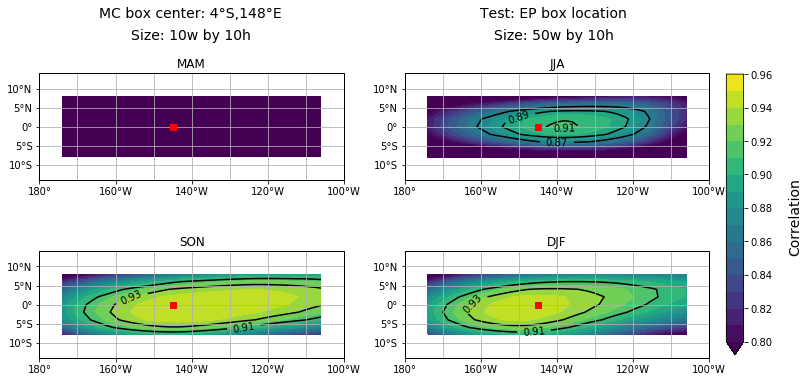

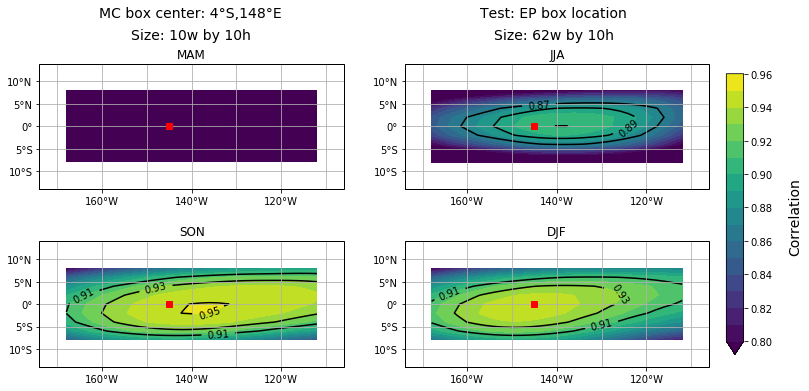

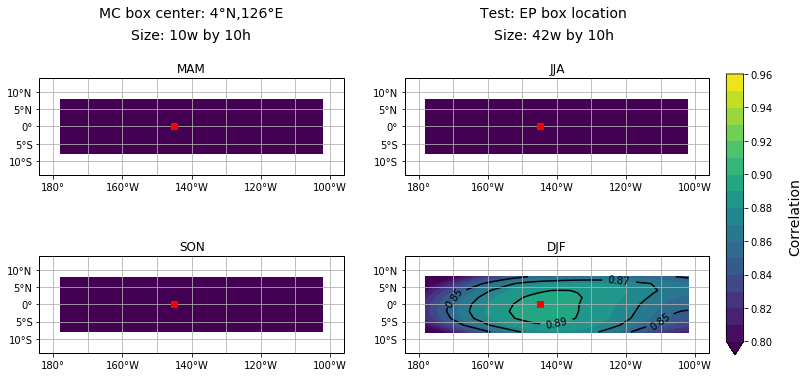

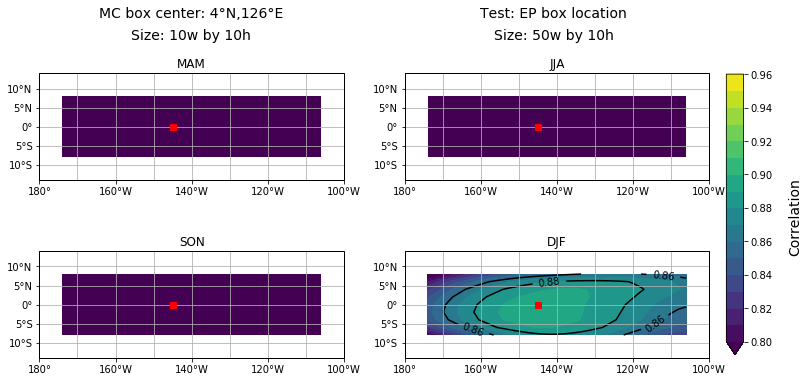

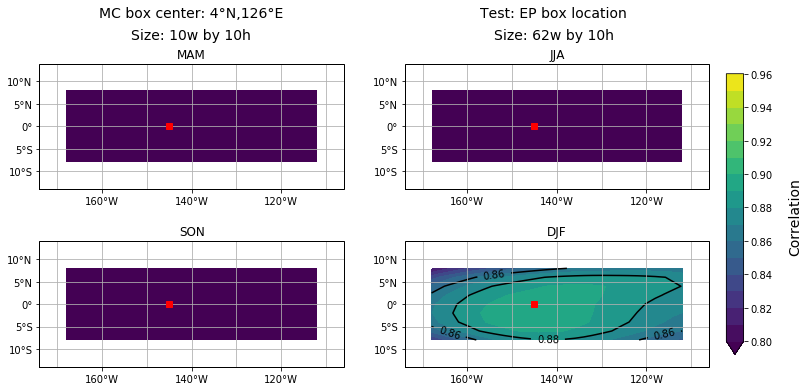

In [45]:
'''
   Using two degrees of freedom method to use selected final
   MC box options to search for EP boxes. Hold MC box constant
   by using box center/dimensions selected for above. Then, hold
   EP box height and width constant. Search across all EP boxes 
   that fully fit within EP domain by correlating NDI for each
   EP box option with the respective GPCP Precipitation PC 1
   used to choose it.
   
   EP sizes chosen: 42w by 10h, 50w by 10h, 62w by 10h.
   
   I would select 40w/60w by 10h, but I would have to make the plotted 
   grid point correlations to be non-centered since it is a 2° by 2°
   with centered grid points (other option is 38w/58w). I would have to 
   use the nino trim function I created for Niño index re-creation, but for 
   this purpose it makes little difference. I am testing how a wider/smaller 
   EP box relative to the Niño 3.4 SST box would affect correlations. 
   Focus was to verify the use of a 50w by 10h box that mirrors the Niño 3.4 SST 
   region since that is what I used in the 2 degrees of freedom search above.
   
   EP region dimensions:
   15°S-15°N,160°E-80°W (Same as eight degrees of freedom search)
   
   MC box option 1: 
   0°,148°E- 30w by 18h selected using SON/DJF of tropical/global 
   precipitation PC 1.
   
   MC box option 2:
   4°S,148°E- 10w by 10h selected using SON/DJF of tropical/global
   precipitation PC 1.
   
   MC box option 3:
   4°N,126°E- 10w by 10h selected using DJF of northern hemisphere
   precipitation PC 1.
'''

epreg_size_latr = SSTll.latr(14,-14) 
epreg_size_lonr = SSTll.lonr(160,-80)

#Edges of MC region to use in for loop
epreg_lat_n = SSTlats[epreg_size_latr[0]]
epreg_lat_s = SSTlats[epreg_size_latr[1]]

epreg_lon_w = SSTlons[epreg_size_lonr[0]]
epreg_lon_e = SSTlons[epreg_size_lonr[1]]


#1/2 heights and widths that match
#gridpoint spacing. using SSTll.latr/lonr
#properly indexes the array to get
#correct box heights desired.

#EP box dimension information
#(42w by 10h,50w by 10h,62w by 10h)
epw = [20,24,30]
eph = [4,4,4]

#MC box coordinates/dimension
#information
mclat_c = [148,148,126]
mclon_c = [0,-4,4]
mch = [8,4,4]
mcw = [14,4,4]

cbarticks = np.round(np.arange(0.8,0.97,0.01),2)

title_mcbox = ['MC box center: 0°,148°E','MC box center: 4°S,148°E','MC box center: 4°N,126°E']
title_mcbox_dim = ['Size: 30w by 18h','Size: 10w by 10h','Size: 10w by 10h']
title_epbox = 'Test: EP box location'
title_epbox_dim = ['Size: 42w by 10h','Size: 50w by 10h','Size: 62w by 10h']

season_name = ['MAM','JJA','SON','DJF']
'''
   Plot figures. Also, plot red box denote box center
   location of Nino 3.4 region.
   
   Note: If plots are dark, they fall outside of colorbar
         range. Only interested in the boxes that have
         strongest correlations.
'''
for mcbox in range(3):
    if mcbox == 0 or mcbox == 1:
        precip_pc1 = GPCP_global_pcTS
    else:
        precip_pc1 = GPCP_nhp_pcTS
        
        
    for epboxsize in range(3):
        #Trim size of plots below according to eph and epw of box
        #based on EP region west and EP region east
        #longitude boundaries.
        #Leave some white space. What is plotted still represents
        #the box centers that fully fit within EP region domain.
        epw_trim_w = 160 + epw[epboxsize]-4
        epw_trim_e = -80 - epw[epboxsize]+4
        
        epreg_trim_lonr = SSTll.lonr(epw_trim_w,epw_trim_e)
                
        #meshgrid to contour values in loop
        lon2d, lat2d = np.meshgrid(SSTlons[epreg_trim_lonr[0]:epreg_trim_lonr[1]], 
                                   SSTlats[epreg_size_latr[0]:epreg_size_latr[1]])
        
        c = np.zeros((epreg_size_latr[1]-epreg_size_latr[0],epreg_trim_lonr[1]-epreg_trim_lonr[0]))

        fig = plt.figure(figsize=(12,6)) 
        
        for season in range(4):    
            idx_subplot = season + 1
            ax = fig.add_subplot(2,2,idx_subplot,
                                 projection=ccrs.PlateCarree(central_longitude=-180))
            plt.set_cmap('viridis')
            ax.coastlines(resolution='110m')
        
            ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                         ylocs = [-15,-10,-5,0,5,10,15], 
                         xlocs=[170,180,190,200,210,220,230,240,250,260,270])

            #remove gridline labels from top and right side of plots
            ax.xlabels_top = False
            ax.xlabels_bottom = True
            ax.ylabels_left = True
            ax.ylabels_right = False
            #Prints out latitude and longitude with proper coordinate system
            ax.set_xticks([180,200,220,240,260], crs = ccrs.PlateCarree())
            ax.set_yticks([-15,-10,-5,0,5,10,15], crs = ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter()
            lat_formatter = LatitudeFormatter()
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
            
            #calculate MC box time series for each season
            mcbox_latr = SSTll.latr(mclat_c[mcbox]-mch[mcbox],mclat_c[mcbox]+mch[mcbox])
            mcbox_lonr = SSTll.lonr(mclon_c[mcbox]-mcw[mcbox],mclon_c[mcbox]+mcw[mcbox])
            mcbox_loop = SST4_gpcp_len[season,:,mcbox_latr[0]:mcbox_latr[1],mcbox_lonr[0]:mcbox_lonr[1]]
            mcbox_loop_reshape = SSTbox.reshape(SSTbox.shape[0],SSTbox.shape[1]*SSTbox.shape[2]) 
            mcbox_loop_mean = np.zeros(nyears_gpcp,)
            for years in range(nyears_gpcp):
                mcbox_loop_mean = np.nanmean(mcbox_loop_reshape,axis=1)
            
            for ilat in range(epreg_size_latr[0],epreg_size_latr[1]):
                epbox_lat_center = SSTlats[ilat]
                epbox_n = int(epbox_lat_center + eph[epboxsize])
                epbox_s = int(epbox_lat_center - eph[epboxsize])
            
                epbox_latr = SSTll.latr(epbox_n,epbox_s)
            
                #Conditions to make sure EP box edges to not extend past the MC region size.
                #Does if condition 1 or 2 equals 0.
                if SSTlats[epbox_latr[0]] >= epreg_lat_n or SSTlats[epbox_latr[1]] <= epreg_lat_s:
                    cond1 = 0
                else:
                    cond1 = 1
                
                for ilon in range(epreg_trim_lonr[0],epreg_trim_lonr[1]):                
                    epbox_lon_center = SSTlons[ilon]
                
                    epbox_w = int(epbox_lon_center - epw[epboxsize])
                    epbox_e = int(epbox_lon_center + epw[epboxsize])
                    epbox_lonr = SSTll.lonr(epbox_w,epbox_e)
                
                    if SSTlons[epbox_lonr[0]] <= epreg_lon_w or SSTlons[epbox_lonr[1]] >= epreg_lon_e:
                        cond2 = 0
                    else:
                        cond2 = 1
                        
                    epbox = SST4_gpcp_len[season,:,epbox_latr[0]:epbox_latr[1],epbox_lonr[0]:epbox_lonr[1]]
                    epbox_reshape = epbox.reshape(epbox.shape[0],epbox.shape[1]*epbox.shape[2]) #reshape to take mean
                    epbox_mean = np.nanmean(epbox_reshape, axis = 1) #SST box time series
                    NDI = epbox_mean - mcbox_loop_mean
                    #1st and 2nd if/else statment make correlation nan if MC box
                    #timeseries is NaN (no SST values) or if calculated MC box
                    #edges exceed the boundaries of the MC region
                    if math.isnan(SSTbox_mean[0]) == True:
                        c[ilat-epreg_size_latr[0],ilon-epreg_trim_lonr[0]] = np.nan
                    elif cond1 == 0 or cond2 == 0:
                        c[ilat-epreg_size_latr[0],ilon-epreg_trim_lonr[0]] = np.nan
                    else:
                        corr_loop = np.corrcoef(NDI,precip_pc1[season,:,0])[0,1] 
                        c[ilat-epreg_size_latr[0],ilon-epreg_trim_lonr[0]] = corr_loop
        
            shading=ax.contourf(lon2d,lat2d,c,cbarticks,
                                transform=ccrs.PlateCarree(),extend = 'min')
            #Plot red box in each figure to denote
            #box center location of Nino 3.4 region
            #x = 35, uses distance from dateline (180°)
            #y = 0, equator
            ax.plot(35,0,"s",color='red')
            #finding out cmin and cmax are for
            #each season
            c_no_nan = c[~np.isnan(c)]
            cmin = np.min(c_no_nan)
            cmax = np.max(c_no_nan)
            #only interested in plotting contours for the boxes
            #that have values that fit within colorbar range
            if cmax <= cbarticks[7]:
                ctr = ax.contour(lon2d,lat2d,c,cbarticks,
                                transform=ccrs.PlateCarree())
            else:
                cmax = np.round(cmax,2)
                idx = int(np.where(cbarticks==cmax)[0])
                ctr = ax.contour(lon2d,lat2d,c,cbarticks[idx-4:idx+2:2],
                                 colors='k',linestyles='solid',
                                 transform=ccrs.PlateCarree())
                ax.clabel(ctr,cbarticks[idx-4:idx+2:2],inline=True,colors='k',fmt='%.2f')
        
            plt.title(season_name[season])
    
        cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.65]) #input: left, bottom, width, height
        cbar = fig.colorbar(shading, cax=cbar_ax, shrink = 0.8)
        cbarlabel = fig.text(1, 0.5, 'Correlation', ha='center',
                         va='center',rotation='vertical', fontsize = 14)
    
        header_mc = fig.text(0.3,0.97,title_mcbox[mcbox],
                             ha='center', va='center',fontsize = 14)
        header2_mc = fig.text(0.3,0.92,title_mcbox_dim[mcbox],
                              ha='center',va='center',fontsize=14)
        header_ep = fig.text(0.72,0.97,title_epbox,
                             ha='center',va='center',fontsize=14)
        header2_ep = fig.text(0.72,0.92,title_epbox_dim[epboxsize],
                              ha='center',va='center',fontsize=14)

In [46]:
'''
   Final NDI options for future testing from thesis: 
   
   1. MC box: 0°,148°E- 30w by 18h selected using SON/DJF of
                        tropical/global precipitation PC 1.
      EP box: 0°,145°W- (50w by 10h, mirrors the Niño 3.4 region)
   
   2. MC box: 4°S,148°E- 10w by 10h selected using SON/DJF of 
                          tropical/global precipitation PC 1.
      EP box: 0°,145°W- (50w by 10h, mirrors the Niño 3.4 region)
      
   MC box option selected using northern hemisphere precipitation
   PC 1 eliminated due to weaker correlations than MC box options 
   for NDI options 1 and 2 and for correlations only exceeding 0.8
   for EP box options in DJF.
   
   Calculate correlations of each box with GPCP global PC 1 for 
   standard seasons. 
'''

#nino3pt4Season[season,years] = np.mean(nino3pt4monthly[ym:ym+3])


season_names = ['MAM:','JJA:','SON:','DJF:']

mclats = [0,-4]
mclons = [148,148]

mch = [8,4]
mcw = [14,4]

#start month for calculations of NDI boxes
smonth = (GPCPdtime[0].year-SSTdtime[0].year)*12

#total number of months to calculate
#(January 1979 through February of 2021)
month_count = nyears_gpcp*12 + 2

NDI_opts = np.zeros((2,month_count))
for options in range(2):
    mc_north = mclats[options] + mch[options]
    mc_south = mclats[options] - mch[options]
    
    mc_east = mclons[options] + mcw[options]
    mc_west = mclons[options] - mcw[options]
    
    mc_latr = SSTll.latr(mc_north,mc_south)
    mc_lonr = SSTll.lonr(mc_east,mc_west)
    mc_box = np.zeros(month_count,)
    for months in range(month_count):
        ind_store = smonth - smonth + months
        ind_calcs = smonth + months
        mc_box[ind_store] = np.nanmean(SST[ind_calcs,mc_latr[0]:mc_latr[1],
                                                     mc_lonr[0]:mc_lonr[1]])
    
    #SST goes through 10/2021, so omit
    #values for it to go through 02/2021
    ep_box = nino3pt4monthly[smonth:-8]
    for months in range(month_count):
        NDI_opts[options,months] = ep_box[months] - mc_box[months]
        

NDI_opts_seasons = np.zeros((2,4,nyears_gpcp))
for option in range(2):
    for season in range(4):
        for year in range(nyears_gpcp):
            month_idx = 2 + year*12 + 3*season
            NDI_opts_seasons[option,season,year] = np.mean(NDI_opts[option,month_idx:month_idx+3])

In [48]:
'''
   Initial test: Comparison of correlations (NDI 
   options from thesis vs. ONI) with GPCP global
   PC 1
'''
#from earlier cell to index ONI I calculated
idx_start_calcs = gpcp_idx_beg - my_oni_idx_beg
season_name = ['MAM:','JJA:','SON:','DJF:']
print('Seasonal correlations with GPCP global PC 1','\n')
for inds in range(3):
    if inds == 0:
        print('NDI option 1')
    elif inds == 1:
        print('NDI option 2')
    else:
        print('ONI')
    for season in range(4):
        if inds != 2:
            print(season_name[season],np.round(np.corrcoef(NDI_opts_seasons[inds,season,:],
                                                           GPCP_global_pcTS[season,:,0])[0,1],3))
        else:
            idx = 3 + 3*season + idx_start_calcs
            print(season_name[season],np.round(np.corrcoef(my_oni_vec_trim[idx::12],
                                               GPCP_global_pcTS[season,:,0])[0,1],3))
            
        if season == 3 and inds != 2:
            print('\n')

Seasonal correlations with GPCP global PC 1 

NDI option 1
MAM: 0.859
JJA: 0.899
SON: 0.952
DJF: 0.961


NDI option 2
MAM: 0.83
JJA: 0.892
SON: 0.95
DJF: 0.957


ONI
MAM: 0.832
JJA: 0.896
SON: 0.936
DJF: 0.957
